# Autoencoders
page 415<br>
For details, see
- https://github.com/ageron/handson-ml/blob/master/15_autoencoders.ipynb,
- https://stackoverflow.com/questions/10019456/usage-of-sys-stdout-flush-method,
- https://en.wikipedia.org/wiki/Matryoshka_doll,
- https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder,
- https://datascience.stackexchange.com/questions/35741/latent-loss-in-variational-autoencoder-drowns-generative-loss, and
- the annotated document "LatentLoss_VAE.pdf".

Autoencoders are artificial neural networks that learn low-dimensional representations – **codings** - of input data without supervision (the training set is unlabeled). The codings are useful for **dimensionality reductions** and for **unsupervised pretraining** of other deep neural networks. They can also be used as **generative models** that randomly produce data similar to the training data.

Given an input, autoencoders return at best that input as output. The point is to do this under certain constraints, i.e., with reduced dimensions or with random noise. Autoencoders thus need to learn the patterns that are found in the training data. The codings are the byproduct of an autoencder's attempt to learn the **identity operation**.
## Efficient Data Representations
page 416<br>
Consider the following two sequences.
- 40, 27, 25, 36, 81, 57, 10, 73, 19, 68
- 50, 25, 76, 38, 19, 58, 29, 88, 44, 22, 11, 34, 17, 52, 26, 13, 40, 20

Naïvely, the first sequence should be easier to reproduce since it is shorter and thus easier to memorize than the second sequence. But the second sequence follows an easy pattern: even number are followed by their half and odd numbers by their triple plus 1. So to reproduce the second sequence one only needs to memorize the rules, the initial number, and the length of the sequence. By constraining autoencoders in certain ways, they are forced to find such patterns instead of just copying the input to the output.<br>
In the early 1970s, William Chase and Herbert Simon found that expert chess players could memorize the positions of all chess figures by looking at the board for only about 5 seconds. But only for realistic configurations – not for impossible ones. So expert players can't necessarily memorize more, they just know the rules much better and use that information to restore the board's configuration (https://goo.gl/kSNcX0).<br>
In order to have autoencoders learn patterns from data and then recreate the data from the data (much like the chess players), they consist of an **encoder** (or **recognition network**) and a **decoder** (or **generative network**). A simple example for an autoencoder is a Mulit-Layer Perceptron (MLP, chapter 10) where the number of outputs equals the number of inputs and the only hidden layer has less neurons than the input (and output) layer. An autoencoder's output is sometimes referred to as its **reconstruction** and for training, the cost function contains a **reconstruction loss** to penalize reconstructions that differ from the input. An autoencoder that cannot copy its input to its output because of a *dimensionality bottleneck* (as just described) is called **undercomplete**. (And for autoencoders, undercompleteness is not a bad thing.)
## Performing PCA with an Undercomplete Linear Autoencoder
page 417<br>
If the undercomplete autoencoder uses linear activation functions and the mean squared error as a cost function, then it can be shown that it ends up doing Principal Component Analysis (PCA, see chapter 8). With additional code from github, this is easy to do.

In [1]:
# imports and other useful things
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
# build 3D dataset
rnd.seed(42)
m = 200                                    # instances
w1, w2 = 0.1, 0.3                          # weights
noise = 0.1                                # noise strength
angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5 # m random angles
data = np.empty((m, 3))                    # 3-dimensional data
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2 # dimensions 1, ...
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2              # ... 2, and ...
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)     # ... 3 are based on the same data (+ noise)
# normalize data and make training and test sets
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100]) # train and apply the StandardScaler instance on the training data
X_test = scaler.transform(data[100:])      # apply it on the test data
print(X_train.shape, X_test.shape)         # print the dataset shapes

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

(100, 3) (100, 3)


After the usual helper and import commands and the creation of the dataset, we now construct a simple undercomplete autoencoder, train it, and display its codings (which we obtain after training is complete).

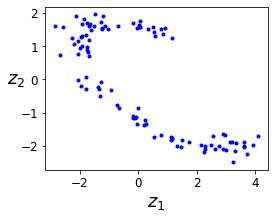

In [2]:
reset_graph()        # always a good idea
n_inputs = 3         # 3D inputs
n_hidden = 2         # 2D codings
n_outputs = n_inputs # 3D outputs
learning_rate = 0.01 # learning rate
n_iterations = 1000  # training iterations
# constuction phase
X = tf.placeholder(tf.float32, shape=[None, n_inputs])       # 3D input layer
hidden = tf.layers.dense(X, n_hidden)                        # 2D hidden layer
outputs = tf.layers.dense(hidden, n_outputs)                 # 3D output layer
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # mean squared error
optimizer = tf.train.AdamOptimizer(learning_rate)            # optimizer
training_op = optimizer.minimize(reconstruction_loss)        # specify training operation
init = tf.global_variables_initializer()                     # initializer
codings = hidden                                             # we will want to check the codings
# execution phae
with tf.Session() as sess:                            # start a tensorflow session
    init.run()                                        # initialize the variables
    for iteration in range(n_iterations):             # loop over iterations
        training_op.run(feed_dict={X: X_train})       # no labels: the autoencoder just tries to recreate the input
    codings_val = codings.eval(feed_dict={X: X_test}) # training complete: time to get the codings for the test set
# show codings (2D)
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

As is clear from Figure 15-2 in the book (on page 419), the above **plot shows the two principal components** with the largest variance, thus **preserving as much information as possible**.
## Stacked Autoencoders
page 419<br>
Like other neural networks, autoencoders may have multiple hidden layers. More hidden layers make the autoencoder more powerful. However, one must pay attention not to make the autoencoder too powerful. That could be the case if the autoencoder can easily reproduce the inputs by assigning numbers to them such that the encoder assigns different instances different numbers and the decoder simply inverts this. The architecture of a autoencoders is usually symmetrical. For example, an MNIST autoencoder might have 784 input [output] neurons, 300 neurons in the following [preceding] layer, and 150 neurons in the central / codings layer.
### TensorFlow Implementation
page 420<br>
The following code implements an autoencoder for MNIST as described above. It should look fairly familiar but for the fact that there are no labels (no `y`).

In [3]:
# further imports
import sys
from functools import partial
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
### construction phase
reset_graph()
# architecture
n_inputs = 28 * 28 # 784 neurons for MNIST
n_hidden1 = 300
n_hidden2 = 150    # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs
# training details
n_epochs = 5
batch_size = 150
learning_rate = 0.01
l2_reg = 0.0001
# building
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu,
                         kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)                       # codings
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))       # MSE (the input shall be reconstructed)
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) # get the regularization losses and add them to ...
loss = tf.add_n([reconstruction_loss] + reg_losses)                # ... the MSE to get the total loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()                                           # saver node (not in book)
### execution phase
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")       # from github
            sys.stdout.flush()                                                # see contribution of "Andrew Clark" ...
            # ... on https://stackoverflow.com/questions/10019456/usage-of-sys-stdout-flush-method
            # the above command seems to be unnecessary on macOS but might be needed on other systems
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})                     # y_batch not needed for autoencoder
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})         # training loss of this epoch
        print("\r{}".format(epoch), "Train MSE:", loss_train)                 # print training loss
        saver.save(sess, "./tf_logs/15_AEs/1_MNIST/my_model_all_layers.ckpt") # save current model

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train MSE: 0.020401113
1 Train MSE: 0.01141915
2 Train MSE: 0.010222081
3 Train MSE: 0.009899909
4 Train MSE: 0.010372396


Nice. All of this works as expected. Now, we will visualize the original (left) and reconstructed digits (right) using further helper functions shown on the github link further above.

INFO:tensorflow:Restoring parameters from ./tf_logs/15_AEs/1_MNIST/my_model_all_layers.ckpt


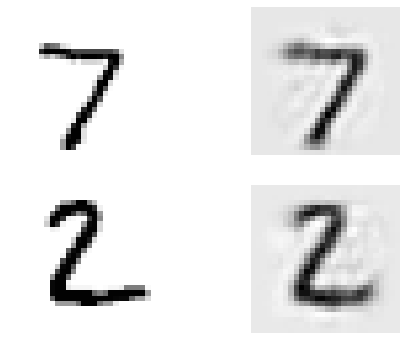

In [4]:
# show in MNIST instance in grayscale
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
# show original and reconstructed digits for n_test_digits instances
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
    # obtain output from session
    with tf.Session() as sess:
        # restore model if path is provided
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
    # make plots of original and reconstruction for every "digit_index"
    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
# apply the above function to instances of the trained model
show_reconstructed_digits(X, outputs, "./tf_logs/15_AEs/1_MNIST/my_model_all_layers.ckpt")

### Tying Weights
page 421<br>
When an autoencoder is indeed symmetrical – just like the one above – a common and meaningful thing to do is to **tie the weights** of the decoder to those of the encoder in a way that reflects that symmetry. The manual implementation with TensorFlow is a bit verbose (it uses unusually much code) but – in this case – still more convenient than relying on TensorFlow's `dense()` layer function.

In [5]:
### construction
# architecture
reset_graph()
n_inputs = 28 * 28 # 784 MNIST
n_hidden1 = 300
n_hidden2 = 150    # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs
# training details
learning_rate = 0.01
l2_reg = 0.0005
n_epochs = 5
batch_size = 150
# definitions
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()
# weights
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")
# biases
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")
# layers
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4
# cost function
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss
# training step
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
# initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()
### execution
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./tf_logs/15_AEs/2_Tying/my_model_tying_weights.ckpt")

0 Train MSE: 0.015067337
1 Train MSE: 0.017049927
2 Train MSE: 0.017900065
3 Train MSE: 0.017234083
4 Train MSE: 0.015850084


A few things are worth pointing out, here:
- Both `weights3` and `weights4` are not variables because they are tied to `weights2` and `weights1`, respectively.
- Since they are no variables, there is no point in regularizing them.
- Biases are never tied and never regularized.

### Training One Autoencoder at a Time
page 422<br>
Symmetric autoencoders with $1+2n$ hidden layers (*stacked* autoencoders) can be interpreted as autoencoders of autencoders, much like **Matryoshka dolls** (see link above). Consequently, the autoencoders of autoencoders can be trained one at a time. This way, very deep autoencoders can be trained. And it can be done in different fashions: with different graphs or with one and the same graph but different training phases. The first option is not shown in the book but we shall reproduce it here.

0 Train MSE: 0.018517498
1 Train MSE: 0.01868246
2 Train MSE: 0.018467506
0 Train MSE: 0.0044959383
1 Train MSE: 0.004276294
2 Train MSE: 0.0048194486
3 Train MSE: 0.004666596
4 Train MSE: 0.004436274


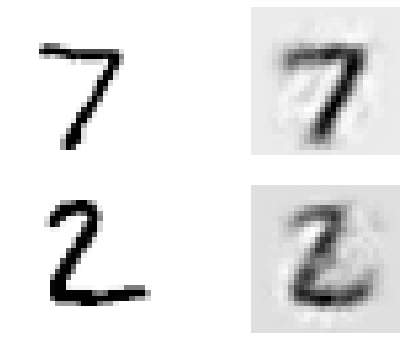

In [6]:
# everything github
reset_graph()
# function that trains an autoencoder
def train_autoencoder(X_train, n_neurons, n_epochs, batch_size, learning_rate = 0.01, l2_reg = 0.0005,
                      seed=42, hidden_activation=tf.nn.elu, output_activation=tf.nn.elu):
    # next is the crucial step: everytime this function is called (for every "Matryoshka level"), a new graph is used
    graph = tf.Graph()              # get graph and make ...
    with graph.as_default():        # ... it the default graph
        tf.set_random_seed(seed)    # random seed for tensorflow
        n_inputs = X_train.shape[1] # number of features
        X = tf.placeholder(tf.float32, shape=[None, n_inputs]) # input layer
        # define an own fully connected layer ...
        my_dense_layer = partial(tf.layers.dense, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        # ... and use it to build the coding and output layer of the current "Matryoshka level"
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))       # the reconstruction loss and the ...
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) # ... regularization loss yield the ...
        loss = tf.add_n([reconstruction_loss] + reg_losses)                # ... total cost function (as before)
        optimizer = tf.train.AdamOptimizer(learning_rate) # optimizer
        training_op = optimizer.minimize(loss)            # training operation
        init = tf.global_variables_initializer()          # initializer (no saver this time)
    with tf.Session(graph=graph) as sess: # run a session using the graph specified above
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        # get all trainable variables, in particular weights and biases
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        # cache the output of the hidden layer
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return (hidden_val,                 # cached output of hidden layer
                params["hidden/kernel:0"],  # weights of hidden layer
                params["hidden/bias:0"],    # bias of hidden layer
                params["outputs/kernel:0"], # weights of output layer
                params["outputs/bias:0"])   # bias of hidden layer
# use the above function for two "Matryoshka levels"
phase1_out = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=3, batch_size=150, output_activation=None)
hidden_output, W1, b1, W4, b4 = phase1_out  # cached output, weights and bias of hidden layer, and for output layer
phase2_out = train_autoencoder(hidden_output, n_neurons=150, n_epochs=5, batch_size=150)
_, W2, b2, W3, b3 = phase2_out              # as before but not cached output
# reset the graph and build the network with the parameters we have just collected
reset_graph()
n_inputs = 28*28                            # MNIST: 784 (may have changed in the above "train_autoencoder" function)
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4
# display input and output
show_reconstructed_digits(X, outputs)

So this shows how it works when **two different graphs** are used. **Now**, we turn to the approach using **only one graph**, as shown in the book. The book also features Figure 15-5 (on page 423). It looks quite complicated but might still be used to clarify things.

In [7]:
### github
reset_graph()
### construction
# architecture
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs
# training details
learning_rate = 0.01
l2_reg = 0.0001
n_epochs = [4, 4]
batch_sizes = [150, 150]
# layer details (activation, regularization, initialization)
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")
# layers
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4
### book
optimizer = tf.train.AdamOptimizer(learning_rate)                              # optimizer
### execution
with tf.name_scope("phase1"):                                                  # phase 1
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4                    # skip layers 2 and 3: use hidden1
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X)) # reconstruction loss
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)            # regularization loss (no tying!)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss                 # total loss in phase 1
    phase1_training_op = optimizer.minimize(phase1_loss)                       # training op in phase 1
with tf.name_scope("phase2"):                                                  # phase 2
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))  # focus on the middle part: 1, 2, and 3
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)            # regularization loss of layers 2 and 3
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss                 # total loss in phase 2
    train_vars = [weights2, biases2, weights3, biases3]                        # train only these variables
    phase2_training_op = optimizer.minimize(phase2_loss, var_list =train_vars) # training operation in phase 2
### github
init = tf.global_variables_initializer()                                       # initializer node
saver = tf.train.Saver()                                                       # saver node
training_ops = [phase1_training_op, phase2_training_op]                        # list of training operations
reconstruct_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]  # list of reconstruction losses
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))                   # final (overall) reconstruction loss
with tf.Session() as sess:                                                     # start session
    init.run()                                                                 # initialize all variables
    for phase in range(2):                                                     # loop over phases
        print("Training phase #{}".format(phase + 1))                          # print current phase
        for epoch in range(n_epochs[phase]):                                   # loop over epochs
            n_batches = mnist.train.num_examples // batch_sizes[phase]         # number of batches
            for iteration in range(n_batches):                                 # loop over iterations
                print("\r{}%".format(100 * iteration // n_batches), end="")    # show percentage of epoch
                sys.stdout.flush()                                             # do print now
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])  # get batch
                sess.run(training_ops[phase], feed_dict={X: X_batch})          # run training operation
            loss_train = reconstruct_losses[phase].eval(feed_dict={X:X_batch}) # get current reconstruction loss ...
            print("\r{}".format(epoch), "Train MSE:", loss_train)              # ... and print it
            saver.save(sess, "./tf_logs/15_AEs/3_SingleGraphStack/my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})     # get overall reconstruction loss ...
    print("Test MSE:", loss_test)                                              # ... on test set and print it

Training phase #1
0 Train MSE: 0.0073349117
1 Train MSE: 0.0078198435
2 Train MSE: 0.007697416
3 Train MSE: 0.0074176565
Training phase #2
0 Train MSE: 0.49426538
1 Train MSE: 0.006815778
2 Train MSE: 0.003242379
3 Train MSE: 0.0025059856
Test MSE: 0.009807365


**Suggestion or Tip**<br>
Since hidden layer 1 is frozen during phase 2, its output will always be the same for any given training instance. To avoid having to recompute the output of hidden layer 1 at every single epoch, you can compute it for the whole training set at the end of phase 1, then directly feed the cached output of hidden layer 1 during phase 2. This can give you a nice perfromance boost.

An implementation of this suggestion is conveniently shown on github and we shall go through it. It uses almost completely the same code as above but for **caching the output of phase 1** and feeding it trough a dictionary to the training operation in phase 2.

In [8]:
### everything github but comments
with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        # first additional if-statement (caching output of hidden layer 1)
        if phase+1 == 2:                                                    # in phase 2, get the output of hidden ...
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images}) # ... layer 1 and reuse it whenever needed
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                # second additional if-statement (make dictionary according to phase 1 (default) and phase 2 (cached))
                if phase+1 == 2:                                           # in phase 2, randomize ...
                    indices = rnd.permutation(mnist.train.num_examples)    # ... the cached output of hidden layer ...
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}                   # ... 1 and feed it to the ...
                    sess.run(training_ops[phase], feed_dict=feed_dict)     # ... training operation of phase 2
                else:                                                      # in phase 1, get the training batch as ...
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}                               # usual and feed it to the training ...
                    sess.run(training_ops[phase], feed_dict=feed_dict)     # ... operation of phase 1
            loss_train = reconstruct_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./tf_logs/15_AEs/4_StackCached/my_model_with_caching.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.0074969046
1 Train MSE: 0.0077131772
2 Train MSE: 0.0073315497
3 Train MSE: 0.007824379
Training phase #2
0 Train MSE: 0.2864308
1 Train MSE: 0.0060940017
2 Train MSE: 0.0028154477
3 Train MSE: 0.0021938253
Test MSE: 0.009802806


### Visualizing the Reconstruction
page 425<br>
Autoencoder shall mimick an identity function so they can be tested by checking how much their outputs differ from their inputs. Let's restore the previous model (with only one graph) and **compare its reconstructions to the originals!**<br>
Remark: the graph is still the one of the stacked autoencoders with a single graph, even though we have reused it already for demonstrating the caching of the first "Matryoshka level" autoencoder.

./tf_logs/15_AEs/3_SingleGraphStack/my_model_one_at_a_time.ckpt
INFO:tensorflow:Restoring parameters from ./tf_logs/15_AEs/3_SingleGraphStack/my_model_one_at_a_time.ckpt


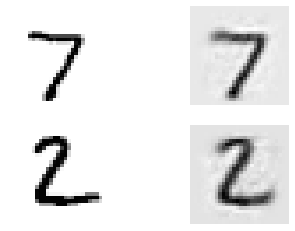

In [9]:
model = "./tf_logs/15_AEs/3_SingleGraphStack/my_model_one_at_a_time.ckpt"
print(model)
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]
with tf.Session() as sess:
    saver.restore(sess, model) # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

this looks actually quite good! The autoencoder seems to perform its task reasonably well.
### Visualizing Features
page 425<br>
Once a neural net (CNN, autoencoder, or else) has been trained, one might wish to inspect what exactly it has learned. One way to do that is to search for the input instances that activate this neuron the most. This is particularly useful for the top hidden layer that – in particular for CNNs – should show high-level, easily interpretable features. Usually, each neurons in the top hidden layer should activate strongly for the same kind of input (e.g. cats). However, this technique does not work so well for lower lying features that are not unique for to a certain class of input instances. So often it is not clear what exactly gets a neuron all excited about.<br>
Another technique is to visualize the weights of a neuron that connect it to the previous layer. Doing this for the first hidden layer visualizes low-level features.

./tf_logs/15_AEs/3_SingleGraphStack/my_model_one_at_a_time.ckpt
INFO:tensorflow:Restoring parameters from ./tf_logs/15_AEs/3_SingleGraphStack/my_model_one_at_a_time.ckpt
(784, 300) (300, 784)


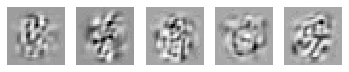

In [10]:
# book, github, and own code
model = "./tf_logs/15_AEs/3_SingleGraphStack/my_model_one_at_a_time.ckpt"
print(model)
with tf.Session() as sess:
    saver.restore(sess, model)
    weights1_val = weights1.eval() # 300 neurons in first hidden layer, each with 784 connections to inpul layer
    print(weights1_val.shape, weights1_val.T.shape)
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_image(weights1_val.T[i])
plt.show()

Well, that certainly looks very "interesting". In the book, Figure 15-7 on page 426 shows similar visualizations of a stacked denoising autoencoder (see the main text below said image in the book). The last of those visualizations seems to look for vertical strokes.<br>
Another approach is to **train the input** in **such** a way **that the activation of a neuron becomes maximal**. This can be achieved by starting with a random image and apply backpropagation on the pixels of that image. Finally, if the autoencoder is used for unsupervised pretraining of a classifier (follows next), the usefulness of the autoencoder's neurons can be assumed to be high if the classifier performs well.
## Unsupervised Pretraining Using Stacked Autoencoders
page 426<br>
In chapter 11 we pointed out the possibility to obtain formidable results with relatively littel training by reusing the lower layer of a highly performant model for a related taks and only train a few top layers on the actual task. In short, this technique works because the lower level features are usually more domain agnostic. In that light, autoencoders can be helpful for unsupervised pretraining on unlabelled data. The idea is to train a stacked autoencoder (usually one Matryoshka level at a time) on the data and then only freeze this autoencoder's layers up to the coding layer. The decoding layers (above the coding layer) are disregarded and replaced by other layers for classification. Only these few layers shall be trained on the little available labelled data. If enough labelled data is available, lower layers of the autoencoder may also be retrained.<br><br>
**General note**<br>
This situation is actually quite common, because building a large unlabeled dataset is often cheap (e.g., a simple script can download millions of images off the internet), but labeling them can only be done reliably by humans (e.g., classifying images as cute or not). Labeling instances is time-consuming and costly, so it is quite common to have only a few thousand labeled instances.<br><br>
The pretraining approach was demonstrated in 2006 by Geoffrey Hinten *et al*. (for restricted Boltzmann machines) and in 2007 by Yoshua Bengio *et al*. (for autoencoders, see http://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf). The following code is a fully connected neural network (or MLP) with only two hidden layers and one output layer. The values for the two hidden layer are imported from a previous autoencoder model on a similar task (and with a compatible architecture). Depending on the value of `freeze` in the code below, these layers will be frozen or they will be retrained. The output layer will always be trained. The code follows largely but not completely from github.

In [11]:
### construction phase
reset_graph()
# architecture
n_inputs = 28 * 28
n_hidden1 = 300     # trainable (and pretrained)
n_hidden2 = 150     # trainable (and pretrained)
n_outputs = 10      # trainable
# training details
freeze = 1          # choose 0 [1] to train [freeze] the two hidden layers (hidden1 and hidden2)
learning_rate = 0.01
l2_reg = 0.0005
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000
# layer details
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()
# 3 layers with trainable parameters
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")
# network building
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3
# cost function
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) # failure cost
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)        # regularization cost
loss = cross_entropy + reg_loss                                                         # total cost
# optimizer and training operation
optimizer = tf.train.AdamOptimizer(learning_rate)
if freeze==0:
    training_op = optimizer.minimize(loss)
    print("training all layers")
else:
    training_op = optimizer.minimize(loss, var_list=[weights3, biases3])
    print("freezing layers 1 and 2")
# define accuracy
correct = tf.nn.in_top_k(logits, y, 1)                  # "True" if "y" is in the top "k=1" "logits" (output ...
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # ... dimension = "y" dimension); build accuracy
# initializer and saver (for importing pretrained variables) nodes
init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2,    # get only the variables for "hidden1" and "hidden2" ...
                                 biases1, biases2])     # ... but not for "logits" (the trainable output layer)
with tf.Session() as sess:
    # initialize the variables but overwrite the weights and biases of hidden1 and hidden2
    init.run()
    pretrain_saver.restore(sess, "./tf_logs/15_AEs/4_StackCached/my_model_with_caching.ckpt")
    # loop over epochs (everything as usual but for the training operation, which - depending on the chosen value ...
    # ... for "freeze" - will train all parameters or only those of the "logits" output layer)
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        # skip saving, here
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

freezing layers 1 and 2
INFO:tensorflow:Restoring parameters from ./tf_logs/15_AEs/4_StackCached/my_model_with_caching.ckpt
0 Train accuracy: 0.87333333	Test accuracy: 0.8773
1 Train accuracy: 0.93333334	Test accuracy: 0.9022
2 Train accuracy: 0.8933333	Test accuracy: 0.9036
3 Train accuracy: 0.94666666	Test accuracy: 0.9101


Do compare the performance when `freeze = 0` vs when `freeze = 1` to see how it works!

Up to now, we have used undercomplete autoencoders (dimension of coding layer smaller than dimension of input) in order to force the autoencoder to learn patterns. But there are also other ways to force an autoencoder to learn something, even when the coding layer is as large or even larger than the input. The latter would be an **overcomplete** autoencoder. Let's have a look at those things now!
## Denoising Autoencoders
page 428<br>
Apart from making an autoencoder undercomplete, one may also constrain it – and thus incite to learn patterns in the data – by feeding the algorithm the default input but adding noise immediately afterwards. Then, the algorithm cannot just copy the noisy data to the output. Instead, it needs to filter the noise out by finding the patterns that govern the data and focus on those patterns. The added noise can stem from a gaussian distribution whose random events are added to the input or by randomly suppressing the input with dropout operation right after the input. Both techniques work very similarly.<br>
The idea to use autoencoders for denoising has been around since the 1980s (e.g., in Yann LeCun's masters thesis). Pascal Vincent showed that autoencoders can be used for feature extraction (https://goo.gl/K9pqcx, 2008) and he introduced stacked denoising autoencoders (https://goo.gl/HgCDIA, 2010).

Now, let's walk the walk and deal with the **TensorFlow Implementation**!

In [12]:
### construction
reset_graph()
# architecture
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150       # codings
n_hidden3 = n_hidden1 # symmetric encoder ...
n_outputs = n_inputs  # ... and decoder
# training details
learning_rate = 0.01
n_epochs = 7
batch_size = 150
# input layer
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
# choice of constraint: added noise or dropout
use_dropout = 1
if use_dropout==0: # apply noise
    print("autoencoder constrained by added noise")
    noise_level = 1.0
    X_noisy = X + noise_level * tf.random_normal(tf.shape(X))               # "tf.shape(X)" is commented on below
    X_next = X_noisy
else:              # apply dropout
    print("autoencoder constrained by dropout noise")
    dropout_rate = 0.3
    training = tf.placeholder_with_default(False, shape=(),name="training") # dropout is only [not] applied during ...
    X_drop = tf.layers.dropout(X, dropout_rate, training=training)          # ... training [testing] (see sess below)
    X_next = X_drop
# hidden layers and output layer
hidden1 = tf.layers.dense(X_next, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")
# cost function (no regularization), optimizer, and training operation
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
# initializer node (saver is not used here)   
init = tf.global_variables_initializer()
### execution
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            if use_dropout==0: # noise: use default training operation
                sess.run(training_op, feed_dict={X: X_batch})
            else:              # dropout: specify that dropout shall be applied during training
                sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)

autoencoder constrained by dropout noise
0 Train MSE: 0.030295799
1 Train MSE: 0.029293908
2 Train MSE: 0.027048983
3 Train MSE: 0.025302099
4 Train MSE: 0.0243453
5 Train MSE: 0.0247929
6 Train MSE: 0.023794234


Do play with `use_dropout` to use added noise (`0`) or dropout (`1`) to constrain the autoencoder. Note that dropout shall only be applied during testing. It is not necessary to set `training` to `False` since we have made this the default. It only needs to be set to `true` during training.

**Warning / caution**<br>
Since the shape of `X` is only partially defined during the construction phase, we cannot know in advance the shape of the noise that we must add to `X`. We cannot call `X.get_shape()` becasue this would just return the partially defined shape of `X` (`[None, n_inputs]`), and `random_normal()` expects a fully defined shape so it would raise an exception. Instead, we call `tf.shape(X)`, which creates an operation that will retrun the shape of `X` at runtime, which will be fully defined at that point.
## Sparse Autoencoders
page 430<br>
Pushing sparsity of the coding layer is also a way to constrain autoencoders. It means that for any instance, the number of firing neurons in the coding layer shall be kept below a certain threshold. Imagine you were only allowed to talk five minutes per day: you would probably think well about what to say instead of just mindlessly waste the potential. This is what drives sparse autoencoders to learn efficient patterns.

To impose **relative sparsity** in the coding layer, one must first **measure its typical sparsity** on the training data. The trainig batch must be sufficiently large as to well represent each neurons average activation. Once this value is known, e.g. $q=0.3$, one may impose a target for its average activation, e.g. $p=0.1$. To achieve that target, **sparsity loss** is imposed on deviations from the target. In priniciple, one could just use some square error in the fashion of $(0.3-0.1)^2$ but the **Kullback-Leibler divergence** (Equation 15-1),
$$D_{KL}(P||Q)=\sum_iP(i)\log\frac{P(i)}{Q(i)}\,,$$
works much better because of its much steeper gradients (see Figure 15-10 on page 431 in the book). In the above formula, $D_{KL}(P||Q)$ denotes the Kullback-Leibler divergence between the imposed probability distribution $P$ and the observed probability distribution $Q$ (all the $P_i$ have to add up to 1, and all the $Q_i$, too). So for a given neuron, the Kullback-Leibler divergence is simply (Equation 15-2)
$$D_{KL}(p||q)=p\log\frac{p}{q}+(1-p)\log\frac{1-p}{1-q}\,,$$
and shown in the plot below.

Note the steepness of the Kullback-Leibler divergence!
Particularly also close to 0 (divergence)!


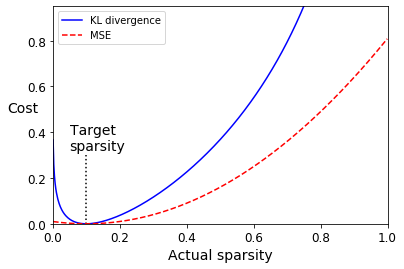

In [13]:
# github only! (apart from comments and last line)
p = 0.1                                               # target probability
q = np.linspace(0.001, 0.999, 500)                    # hypothetical mean probabilities
kl_div = p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))    # Kullback-Leibler divergence values for many q (blue y-data)
mse = (p - q)**2                                      # hypothetical mean squared errors (red y-data)
plt.plot([p, p], [0, 0.3], "k:")                      # black dotted line (vertical)
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14) # "Target sparsity" text
plt.plot(q, kl_div, "b-", label="KL divergence")      # Kullback-Leibler divergence plot
plt.plot(q, mse, "r--", label="MSE")                  # mean squared error plot
plt.legend(loc="upper left")                          # legend
plt.xlabel("Actual sparsity")                         # x-label
plt.ylabel("Cost", rotation=0)                        # y-label
plt.axis([0, 1, 0, 0.95])                             # axes ranges
print("Note the steepness of the Kullback-Leibler divergence!\nParticularly also close to 0 (divergence)!")

Once the sparsity loss is computed for every neuron, one may add the total sparsity loss to the reconstruction loss to obtain the total loss function that the alogrithm trains on. The sparsity loss is usually weighted with a **sparsity weight hyperparameter** that allows the user to tune the sparsity constraint up and down. If the constraint is very weak, the algorithm might reconstruct the input very well by more or less copying the input to the output. And if the constraint is to strong, the coding layer becomes almost inactive, thus leading to poor results. So the hyperparameter must be tuned well!<br><br>
And now to the **TensorFlow Implementation**!

0 Train MSE:  0.14306302 	Sparsity loss:  0.48000106 	Total loss:  0.23906323
1 Train MSE:  0.0601003 	Sparsity loss:  0.008880448 	Total loss:  0.061876386
2 Train MSE:  0.053482294 	Sparsity loss:  0.049979452 	Total loss:  0.06347819
3 Train MSE:  0.048346188 	Sparsity loss:  0.055491075 	Total loss:  0.059444405
4 Train MSE:  0.04506336 	Sparsity loss:  0.010088855 	Total loss:  0.04708113
5 Train MSE:  0.041321483 	Sparsity loss:  0.008463459 	Total loss:  0.043014176
6 Train MSE:  0.038870737 	Sparsity loss:  0.015069475 	Total loss:  0.04188463
7 Train MSE:  0.036700238 	Sparsity loss:  0.024786627 	Total loss:  0.041657563
8 Train MSE:  0.033531196 	Sparsity loss:  0.3194489 	Total loss:  0.097420976
9 Train MSE:  0.030284239 	Sparsity loss:  0.12491542 	Total loss:  0.055267323
10 Train MSE:  0.028432388 	Sparsity loss:  0.34754923 	Total loss:  0.09794223
INFO:tensorflow:Restoring parameters from ./tf_logs/15_AEs/5_Sparse/my_model_with_KL.ckpt


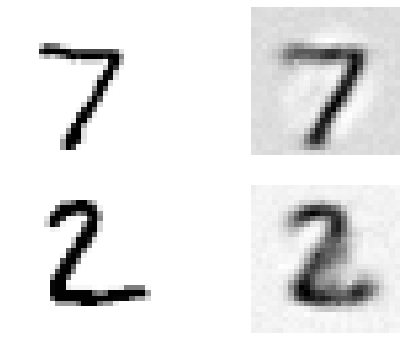

In [14]:
### construction
# architecture
reset_graph()        # always a good idea
n_inputs = 28 * 28   # 784 for MNIST
n_hidden1 = 1000     # 1000 codings, constrained by sparsity
n_outputs = n_inputs # symmetric archtecture (encoder - coding layer - decoder)
# training details
n_epochs = 11        # changed from default 10
batch_size = 1000
def kl_divergence(p, q):                                                    # Kullback-Leibler divergence: the ...
    return p*tf.log(p/q) + (1-p)*tf.log((1-p)/((1-q)))                      # ... arguments must lie in (0, 1)
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2
# layers
X = tf.placeholder(tf.float32, shape=[None, n_inputs])                      # input layer
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)           # coding layer
outputs = tf.layers.dense(hidden1, n_outputs)                               # output layer
# cost function, optimizer, and training operation
hidden1_mean = tf.reduce_mean(hidden1, axis=0)                              # mean activations over current batch
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean)) # Kullback-Leibler for sparsity loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))                # mse for reconstruction loss
loss = reconstruction_loss + sparsity_weight * sparsity_loss                # total (weighted) cost function 
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
# variable initializer and saver node
init = tf.global_variables_initializer()
saver = tf.train.Saver()
### execution phase
with tf.Session() as sess:
    init.run() # initialize variable
    for epoch in range(n_epochs):                                           # loop over epochs
        n_batches = mnist.train.num_examples // batch_size                  # get number of batches
        for iteration in range(n_batches):                                  # iterate over batches
            print("\r{}%".format(100 * iteration // n_batches), end="")     # show progress on current epoch ...
            sys.stdout.flush()                                              # ... and, yes, do show it now
            X_batch, y_batch = mnist.train.next_batch(batch_size)           # get current batch
            sess.run(training_op, feed_dict={X: X_batch})                   # feed only the X_batch (unsupervised)
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss,   # run ...
                                                                         sparsity_loss, loss],  # ... a ...
                                                                        feed_dict={X: X_batch}) # ... session
        print("\r{}".format(epoch), "Train MSE: ", reconstruction_loss_val,                     # print results of ...
              "\tSparsity loss: ", sparsity_loss_val, "\tTotal loss: ", loss_val)               # ... finished epoch
        saver.save(sess,  "./tf_logs/15_AEs/5_Sparse/my_model_with_KL.ckpt")                    # save model
show_reconstructed_digits(X, outputs, "./tf_logs/15_AEs/5_Sparse/my_model_with_KL.ckpt")        # show reconstructions

In the above code, using the logistic activation function (`activation=tf.nn.sigmoid`) for the coding layer ensures that all activations lie in the interval $(0,\,1)$, as required by the Kullback-Leibler divergence.<br>
Using the mean squared error for the reconstruction loss may not be optimal due to its shallow gradients. The cross entropy is often a better choice. But to use it, both the input and the output must be scaled to the interval $(0, \,1)$. Details on this can be found in the book and via the github link above.
## Variational Autoencoders
page 433<br>
In 2014, Diederik Kingma and Max Welling have introduced **variational autoencoders**, one of the most popular types of autoencoders. They differ from quite a bit from most other autoencoders:
- They are *probabilistic autoencoders*, meaning that their **outputs are partly determined by chance, even after training** (as opposed to denoising autoencoders, which use randomness only during training).
- Most importantly, they are *generative autoencoders*, meaning that they **can generate new instances** that look like they were sampled from the training set.

These properties make variational autoencoders similar to Random Boltzmann Machines (RBMs, see Appendix E in the book) but they are easier to train and generation of new instances is much faster since – unlike RBMs – they do not have to reach some *thermal equilibrium*. The basic structure is shared with other types of autoencoders: encoder and decoder are symmetric wrt each other and the coding space is in between. But instead of learning the weihgts and the bias for the coding layer, the goal seems to be to learn means and variances for $n$ separate normal distributions (or other distributions) in such a way that
- for each input there is point in this $n$-dimensional space that leads to an output close to the input and
- coding vectors that lie close to each other in this $n$-dimensional space tend to return similar outputs.

To achieve this, gradient descent on the **latent loss** cost function,<br><br>
`eps = 1e-10 # smoothing term to avoid log(0)`<br>
`lat_loss=0.5*tf.reduce_sum(tf.square(hidden3_sigma)+tf.square(hidden3_mean)-1-tf.log(eps+tf.square(hidden3_sigma)))`,<br><br>
shall be used. It is easy to see that with $\sigma^2=e^{\gamma}$, the latent loss can be rewritten as<br><br>
`lat_loss=0.5*tf.reduce_sum(tf.exp(hidden3_gamma)+tf.square(hidden3_mean)-1-hidden3_gamma)`,<br><br>
but it is not so easy to see why this cost function works. Further details can be found under some of the links listed at the beginning of this notebook and in the annotated document "LatentLoss_VAE.pdf". What follows is an implementation in TensorFlow as shown on github. **Generating Digits** is also demonstrated.

0 Train total loss: 18791.533 	Reconstruction loss: 14682.374 	Latent loss: 4109.1587
1 Train total loss: 17575.0 	Reconstruction loss: 13556.966 	Latent loss: 4018.0347
2 Train total loss: 18016.67 	Reconstruction loss: 13925.4 	Latent loss: 4091.2695
3 Train total loss: 17784.266 	Reconstruction loss: 13960.13 	Latent loss: 3824.1362
4 Train total loss: 16711.764 	Reconstruction loss: 12753.172 	Latent loss: 3958.592
5 Train total loss: 16357.296 	Reconstruction loss: 12576.737 	Latent loss: 3780.5583
6 Train total loss: 16782.922 	Reconstruction loss: 12755.723 	Latent loss: 4027.1982
7 Train total loss: 15681.314 	Reconstruction loss: 11826.11 	Latent loss: 3855.2046
8 Train total loss: 16128.009 	Reconstruction loss: 12227.28 	Latent loss: 3900.7283
9 Train total loss: 15852.836 	Reconstruction loss: 11908.775 	Latent loss: 3944.0605
10 Train total loss: 15474.311 	Reconstruction loss: 11627.691 	Latent loss: 3846.619
11 Train total loss: 15817.809 	Reconstruction loss: 11897.891 

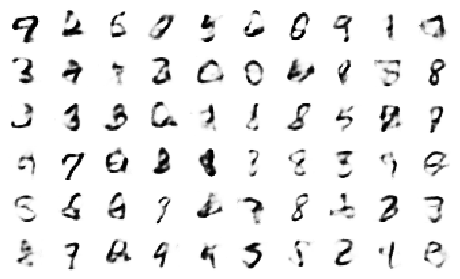

In [15]:
### construction
n_inputs = 28 * 28    # input (MNIST: 784)
n_hidden1 = 500       # encoder
n_hidden2 = 500       # encoder
n_hidden3 = 20        # codings
n_hidden4 = n_hidden2 # decoder
n_hidden5 = n_hidden1 # decoder
n_outputs = n_inputs  # output
# training and inference details
learning_rate = 0.001
n_epochs = 51         # adjusted from default 50
batch_size = 150
n_digits = 60
# own initializer for own dense layer
initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=initializer)
# layers
X = tf.placeholder(tf.float32, [None, n_inputs])                   # input
hidden1 = my_dense_layer(X, n_hidden1)                             # encoder
hidden2 = my_dense_layer(hidden1, n_hidden2)                       # encoder
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None) # coding layer: train the means and the ...
hidden3_gamma = my_dense_layer(hidden2, n_hidden3,activation=None) # ... standard deviations (or gammas, see text) ...
noise = tf.random_normal(tf.shape(hidden3_gamma),dtype=tf.float32) # ... to randomly draw the output of the coding ...
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise       # ... layer, subject to the current instance
hidden4 = my_dense_layer(hidden3, n_hidden4)                       # decoder
hidden5 = my_dense_layer(hidden4, n_hidden5)                       # decoder
logits = my_dense_layer(hidden4, n_outputs, activation=None)       # logits
outputs = tf.sigmoid(logits)                                       # output (activation function applied to logits)
# cross entropy for reconstruction loss, latent loss variational coding layer, total cost, optimizer, and training op.
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# global initializer (saver as usual but skipped here and in session)
init = tf.global_variables_initializer()
### execution
with tf.Session() as sess:
    init.run()
    # loop over epochs
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        # loop over batches
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        # get and print losses for current epoch
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss],
                                                                      feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:",
              reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
    # DIGIT GENERATION (in only 2 lines of code)
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])   # sample n_digits codings from a normal distribution
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd}) # use ongoing session to obtain outputs from codings
# plotting some generated digits (=outputs)
plt.figure(figsize=(8, 50))                  # establish figure
for iteration in range(n_digits):            # loop over digits
    plt.subplot(n_digits, 10, iteration + 1) # establish subplot
    plot_image(outputs_val[iteration])       # plot current digit

Some of these generated "digits" look very convincing while others do not. But we did neither use much traininig nor much fine tuning. Taking that into account, the result is actually surprisingly OK.
## Other Autoencoders
page 437<br>
The success of image recognition, text translation, speech recognition, and other supervised learning tasks have somewhat overshadowed the advances in unsupervised learning. But it is booming! In fact it is booming so strongly that a list of all types of novel autoencoders would be unreasonably long. So here is a brief but by no means exhaustive list of novel autoencoders:
- **Contractive autoencoder** (CAE, https://goo.gl/U5t9Ux)<br>
The autoencoder is constrained during training in such a way that similar inputs will have similar codings.
- **Stacked convolutional autoencoders** (https://goo.gl/PTwsol)<br>
Autoencoders that use convolutional layers, e.g., 2-D convolutions for image reconstruction.
- **Generative stochastic network** (GSN, https://goo.gl/HjON1m)<br>
A version of denoising autoencoders that also allows to generate new data.
- **Winnter-take-all autoencoder** (WTA, https://goo.gl/I1LvzL)<br>
This algorithm is constrained by sparse codings. Sparisity is achieved by taking only the top $k$% activations of the coding layer over an entire training batch (the other activations are set to $0$). A similar WTA approach can be used to produce sparse convolutional autoencoders.
- **Adversarial autoencoder** (https://goo.gl/enC5fB)<br>
One autoencoder is trained to reproduce the input and at the same time another autoencoder is trained to produce inputs that the first autoencoder cannot reproduce well. This pushes the first autoencoder to learn robust codings.

## Exercises
page 438
### 1.-7.
Solutions are shown in Appendix A of the book and in the separate notebook *ExercisesWithoutCode*.
### 8. Let's use a denoising autoencoder to pretrain an image classifier:
- You can use MNIST (simplest), or another large set of images such as CIFAR10 (https://goo.gl/VbsmxG) if you want a bigger challenge. If you choose CIFAR10, you need to write code to load batches of images for training. If you want to skip this part, TensorFlow's model zoo contains tools to do just that (https://goo.gl/3iENgb).
- Split the dataset into an training set and a test set. Train a deep denoising autoencoder on the full training set.
- Check that the images are fairly well reconstructed, and visualize the low-level features. Visualize the images that most activate each neuron in the coding layer.
- Build a classification deep nerual network, reusing the lower layers of the autoencoder. Train it using only 10% of the training set. Can you get it to perform as well as the same classifier trained on the full training set?

In [16]:
print("A solution may follow later.")

A solution may follow later.


### 9. *Semantic hashing*, introduced in 2008 by Ruslan Salakhutdinov and Geoffrey Hinton (https://goo.gl/LXzFX6), is a technique used for efficient *information retrieval*: a document (e.g., an image) is passed through a system, typically a neural network, which outputs a fairly low-dimensional binary vectore (e.g., 30 bits). Two similar documents are likely to have identical or very similar hashes, By indexing each document using its hash, it is possible to retireve many documents similar to ta prticual document alomost instantly, even if there are billions of documents: just compute the hash of the document and look up all documents with that same hash (or hashses differing by just one or two bits). Let's implement semantic hashing using a slightly tweaked stacked autoencoder:
- Create a stacked autoencoder containing two hidden layers below the coding layer, and train it on the image dataset you used in the previous exercise. The coding layer should contain 30 neurons and use the logistic activation function to output values between 0 and 1. After training, to produce the hash of an image, you can simply run it through the autonecoder, take the output of the coding layer, and round every value to the closest integer (0 or 1).
- One neat trick proposed by Salkhutdinov and Hinton is to add Gaussian noise (with zero mean) to the inputs of the coding layer, during training only. In order to preserve a high signal-to-noise ratio, the autoencoder will learn to feed large values to the coding layer (so that the noise becomes negligible). In turn, this means that the logistic function of the coding layer will likely saturate at $0$ or $1$. As a result, rounding the coding to $0$ or $1$ won't distort them too much, and htis will improve the reliability for the hashes.
- Compute the hash of every image, and see if images with identical hashes look alike. Since MNIST and CIFAR10 are labeled, a more objective way to measure the performance of the autoencoder for sematic hashing is to ensure that images with the same hash generally have the same class. One way to do this is to measure the average Gini purity (introduced in Chapter 6) of the sets of images with identical (or very similar) hashes.
- Try fine-tuning the hyperparameters using cross-validation.
- Note that with a labeled dataset, another approach is to train a convolutional neural network (see Chapter 13) for classification, then use the layer below the output layer to produce the hashes. See Jinma Gua and Hianmin Li's 2015 paper (https://goo.gl/i9FTln). See if that performs better.

In [17]:
print("A solution may follow later.")

A solution may follow later.


### 10. Train a variational autoencoder on the image dataset used in the previous exersices (MNIST or CIFAR10), and make it generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples.

In [18]:
print("A solution may follow later.")

A solution may follow later.
